# Python helper file/script for MATLAB

## Optimization file only

If you are on the **monetaryPolicy** project, please use other file `PyLab.ipynb` for your analysis.

This cell sets up the notebook to import numpy, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Pandas, Seaborn, Matplotlib modules.
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

Install `matlab.engine` using this link:

https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

### The cell given below sets up MATLAB for the notebook
Source: https://sehyoun.com/blog/20180904_using-matlab-with-jupyter-notebook.html

In [2]:
import matlab.engine
import io
import scipy.io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())
    
# Starting a MATLAB engine called eng
eng = matlab.engine.start_matlab()

**Note:** Change this to the file path on your computer.

In [3]:
# Adds the MMB.m as well as MMBOPT1.m and MMBOPT2.m folders to the MATLAB engine path"
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB_OPTIONS', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/scripts', nargout=0)

# Important:
The code below sets the coefficients and other data for the PID rule to work.

Check out the coefficients table here:

https://rishab231.github.io/img/coefficients.png

In [4]:
# This sets the coefficients of the monetary policy rule, there are 33 coefficients and len(coefficients) = 33
coefficients = [0, 0, 0, 0, 1.5/4, 1.5/4, 1.5/4, 1.5/4, 
                0, 0, 0, 0, 0, 0.5, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 0]

# Number of the model you want to chooose, please exclude 69-79, 19-22, 27, 59, 65, 68, 81, 97, 98
modelNum = 1

scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))

## **Important:** 
The cell below runs the MMB.m file

In [5]:
eng.MMB(nargout = 0)

### Functions defined to import data for:
* 4 IRF: Impulse Response Function Variables (outputgap, inflation, interest, output) and `modelName`
* All IRF Variables
* 4 ACF: Autocorrelation Function Variables (outputgap, inflation, interest, output)
* **Unconditional Variances**


In [6]:
def getModelName():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    return modelName

def singleModel_irf4():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    irf_4 = irf_4.iloc[:, [i for i in range(1, len(irf_4.columns.values), 2)]]
    irf_4.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    irf_4 = irf_4.reset_index()
    irf_4.index.name = "Period"
    irf_4.drop('index', axis=1, inplace=True)
    return irf_4

def singleModel_allirf():
    old_irf_df = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "all IRFs Mon. Pol. Shock")
    all_irf = old_irf_df.T
    new_header = all_irf.iloc[0] # grab the first row for the header
    all_irf = all_irf[1:] # take the data less the header row
    stripped_headers = [myHeader.strip() for myHeader in np.array(new_header)] # removing trailing whitespaces
    all_irf.columns = stripped_headers # set the header row as the df header
    all_irf["c_t"] = all_irf.index
    all_irf.index = np.arange(0,21,1)
    all_irf.index.name = "Period"

    # This section rearranges the columns
    n = len(list(all_irf.columns.values))
    rearranged = [list(all_irf.columns.values)[-1]] + list(all_irf.columns.values)[:n-1]
    all_irf = all_irf[rearranged]
    return all_irf

def singleModel_acf():
    acf = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "ACF")
    acf = acf.T
    acf_headers = acf.iloc[0] # grab the first row for the header
    acf = acf[1:] # take the data less the header row
    acf_stripped_headers = [myHeader.strip() for myHeader in np.array(acf_headers)] # removing trailing whitespaces
    acf.columns = acf_stripped_headers
    acf = acf.iloc[:, [i for i in range(0, len(acf.columns.values), 2)]]
    acf.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    acf = acf.reset_index()
    acf.index.name = "Period"
    acf.drop('index', axis=1, inplace=True)
    return acf

def unconditionalVariances():
    var4 = pd.read_csv("../mmb-gui-mlab-2.3.2/OUTPUT/variances.csv", names=["interest", "inflation", "outputgap", "output"])
    return var4

In [7]:
singleModel_irf4().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0


In [8]:
singleModel_acf().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,1,1,1,1
1,0.661577,0.716781,0.755958,0.730718
2,0.375576,0.478675,0.590853,0.520949



Calculating `unconditionalVariances` for different models, in an array of `modelNums`

In [9]:
def myVariance(modelNums, coeff):
    variances = dict()
    for modelNum in modelNums:
        eng.MMB(nargout = 0)
        scipy.io.savemat('variables.mat', dict(coefficients=coeff, modelNumber = modelNum))
        modelName = getModelName()
        variances[modelName] = unconditionalVariances().values.tolist()[0]
    return variances

Calculating unconditional variances for different rules

In [10]:
myVariance([1], coefficients)

{'NK_RW97': [0.079687, 0.06191, 0.38900999999999997, 1.1702]}

## Completed tasks:
* Extracted unconditional variances from the MATLAB code as CSV file (in `OUTPUT/variances.csv`)
* Created a `coefficients` matrix which can be used to feed in a User Defined Rule through Python
* Can input `modelNum` to iterate upon when using our User Defined Rule
* Commented out the part that produces visualizations to save time
* Systemize functions which can generate `IRF_4`, `All_IRF`, `ACF` and `ModelName` on call

**Todo:**
* Iterate and call the `unconditionalVariance` function on many models
* Similarly iterate upon and call your `unconditionalVariance` on many user rules (using `coefficients`)

## Optimizations

Optimization in 2 variables - coefficient on lagged quarterly inflation, and coefficient on output gap

In [81]:
# Storing the losses at every iteration
loss_array = []

# Number of the model you want to chooose, please exclude 69-79, 19-22, 27, 59, 65, 68, 81, 97, 98
modelNum = 1

def objFunction(selected_coeff, weights, modelNum):
    coefficients = [0, 0, 0, 0, selected_coeff[0]/4, selected_coeff[0]/4, selected_coeff[0]/4, selected_coeff[0]/4, 
                0, 0, 0, 0, 0, selected_coeff[1], 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 0]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))
    eng.MMB(nargout = 0)
    loss = sum(unconditionalVariances().iloc[0] * weights)
    loss_array.append(loss)
    
    print(loss)
    return loss

Using the initial coefficients of the Taylor rule:
* $\beta^{(\pi_t)} = 1.5$
    * So, the lagged quarterly for 4 recent periods is $\beta$ is 1.5/4
* $\beta^{(y_t)} = 0.5$
    * Coefficient on output gap is 0.5

In [82]:
# Initial coefficients of the Taylor Rule
taylor_coefficients = [1.5, 0.5]

weights = [1,1,1,1]
modelNum = 1
result = scipy.optimize.minimize(objFunction, taylor_coefficients, args = (weights, modelNum), method = "Nelder-Mead")

1.7008069999999997
1.726804
1.6497259999999998
1.626964
1.5833110000000001
1.5389009999999999
1.4718050000000003
1.4296030000000002
1.4296030000000002
1.345804
1.345804
1.345804
1.345804
1.345804
1.378634
1.378634
1.3344179999999999
1.318985
1.318985
1.318985
1.318985
1.32437
1.32437
1.32437
1.311919
1.3164310000000001
1.3092259999999998
1.30447
1.30447
1.30447
1.30447
1.30447
1.30447
1.30447
1.30447
1.305828
1.305828
1.305828
1.302816
1.3038159999999999
1.3021420000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.3009680000000001
1.301306
1.301306
1.301306
1.301306
1.301147
1.301382
1.300899
1.30073
1.300521
1.300521
1.3000639999999999
1.2996569999999998
1.299737
1.298862
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.2980369999999999
1.298429
1.298429
1.298429
1.297827
1.297841
1.29762
1.297421
1.297421
1.

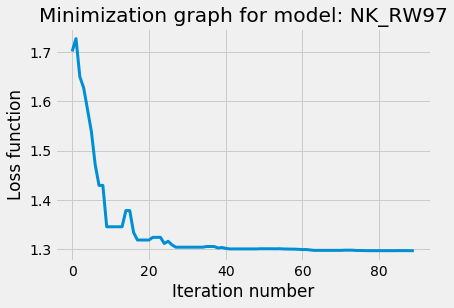

In [83]:
plt.ylabel('Loss function')
plt.xlabel('Iteration number')
plt.title('Minimization graph for model: {}'.format(getModelName()))
plt.plot(loss_array, lw=3)

In [84]:
print(result)

 final_simplex: (array([[0.93787994, 0.69898415],
       [0.93796234, 0.69898033],
       [0.93793945, 0.69893799]]), array([1.297363, 1.29737 , 1.297421]))
           fun: 1.297363
       message: 'Optimization terminated successfully.'
          nfev: 90
           nit: 41
        status: 0
       success: True
             x: array([0.93787994, 0.69898415])


### From Prof. Hawkins Overleaf document

Optimization in 4 variables:
* Coefficient on inflation gap (annual)
* Coefficient on lagged inflation gap (annual)
* Coefficient on output gap
* Coefficient on lagged output gap

`selected_coeff` has $\beta^{(\pi_t)}, \beta^{(\pi_{t-1})}, \beta^{(y_t)}, \beta^{(y_{t-1})}$ 

In [85]:
loss_array_2 = []

def objFunction2(selected_coeff, weights, modelNum):
    coefficients_2 = [0, 0, 0, 0, selected_coeff[0]/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, 
                selected_coeff[1]/4, 0, 0, 0, 0, selected_coeff[2], selected_coeff[3], 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 0]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients_2, modelNumber = modelNum))
    eng.MMB(nargout = 0)
    loss_2 = sum(unconditionalVariances().iloc[0] * weights)
    loss_array_2.append(loss_2)
    print(loss_2)
    return loss_2

### Using Taylor rule coefficients - but as a 4 variable optimization (Overleaf document)

In [86]:
taylor_coeff = [1.5, 0, 0.5, 0]

weights = [1,1,1,1]
modelNum = 1
result_2 = scipy.optimize.minimize(objFunction2, taylor_coeff, args = (weights, modelNum), method = "Nelder-Mead")

1.7008069999999997
1.726804
1.7008459999999999
1.6497259999999998
1.700291
1.651391
1.649977
1.625874
1.591087
1.575029
1.5202939999999998
1.553505
1.510731
1.451017
1.424665
1.340216
1.352353
1.3009789999999999
1.218478
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.174765
1.174765
1.174765
1.174765
1.174765
1.174765
1.172863
1.1978929999999999
1.1978929999999999
1.1978929999999999
1.1737920000000002
1.1737920000000002
1.1737920000000002
1.1737920000000002
1.172921
1.198307
1.198307
1.172876
1.173327
1.170209
1.170209
1.170209
1.170209
1.170209
1.170209
1.1683189999999999
1.172863
1.1706150000000002
1.1706150000000002
1.1692639999999999
1.1692639999999999
1.1664459999999999
1.1646059999999998
1.1702460000000001
1.165619
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246
1.163246

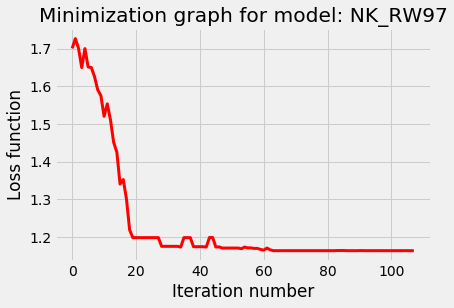

In [87]:
plt.ylabel('Loss function')
plt.xlabel('Iteration number')
plt.title('Minimization graph for model: {}'.format(getModelName()))
plt.plot(loss_array_2, lw=3, color="red")

In [88]:
print(result_2)

 final_simplex: (array([[9.25687726e-01, 5.99761245e-06, 8.35486167e-01, 5.27951695e-04],
       [9.25657062e-01, 6.23946019e-06, 8.35512441e-01, 5.27979220e-04],
       [9.25734026e-01, 6.04072594e-06, 8.35451349e-01, 5.28027811e-04],
       [9.25760639e-01, 6.12728439e-06, 8.35447875e-01, 5.27800887e-04],
       [9.25670220e-01, 6.24041397e-06, 8.35475597e-01, 5.27948382e-04]]), array([1.163172, 1.163172, 1.163191, 1.1632  , 1.1632  ]))
           fun: 1.163172
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 39
        status: 0
       success: True
             x: array([9.25687726e-01, 5.99761245e-06, 8.35486167e-01, 5.27951695e-04])


**Note.** The code below does not work for some reason. Ask Prof. Hawkins.

In [89]:
loss_array_3 = []

def objFunction3(selected_coeff, weights, modelNum):
    coefficients_3 = [0, 0, 0, 0, selected_coeff[0]/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, 
                selected_coeff[1]/4, 0, 0, 0, 0, selected_coeff[2], selected_coeff[3], 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 0]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients_3, modelNumber = modelNum))
    eng.MMB(nargout = 0)
    loss_3 = sum(unconditionalVariances().iloc[0] * weights)
    loss_array_3.append(loss_3)
    print(loss_3)
    return loss_3

In [90]:
hamilton_coeff = [1.42, -1.2, 0.5, -0.48]

weights = [1,1,1,1]
modelNum = 1
result_3 = scipy.optimize.minimize(objFunction3, hamilton_coeff, args = (weights, modelNum), method = "Nelder-Mead")

1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172
1.163172


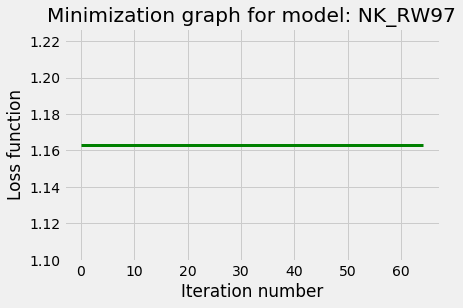

In [91]:
plt.ylabel('Loss function')
plt.xlabel('Iteration number')
plt.title('Minimization graph for model: {}'.format(getModelName()))

# Only the part of loss_array_2 which started with Hamilton coefficients
plt.plot(loss_array_3, lw=3, color="green")

In [92]:
print(result_3)

 final_simplex: (array([[ 1.42      , -1.2       ,  0.5       , -0.48      ],
       [ 1.42006934, -1.2       ,  0.5       , -0.48      ],
       [ 1.42      , -1.20005859,  0.5       , -0.48      ],
       [ 1.42      , -1.2       ,  0.50002441, -0.48      ],
       [ 1.42      , -1.2       ,  0.5       , -0.48002344]]), array([1.163172, 1.163172, 1.163172, 1.163172, 1.163172]))
           fun: 1.163172
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 11
        status: 0
       success: True
             x: array([ 1.42, -1.2 ,  0.5 , -0.48])


In [93]:
result_2.x

array([9.25687726e-01, 5.99761245e-06, 8.35486167e-01, 5.27951695e-04])

## Iterative deepening

Starting with the previous coefficient array `result_2.x` which minimized the variance starting from the **4-degree** Taylor rule (as given in the Overleaf document).

We keep adding an additional degree of freedom by using the previous minimization array as a starting point, in the following manner,:

a. $\beta^{(\pi_t)}, \beta^{(\pi_{t-1})}, \beta^{(\delta y_t)}, \beta^{(\delta y_{t-1})}$

b. $\beta^{(\pi_t)}, \beta^{(\pi_{t-1})}, \beta^{(\delta y_t)}, \beta^{(\delta y_{t-1})}, \beta^{(y_{t})}$

c. $\beta^{(\pi_t)}, \beta^{(\pi_{t-1})}, \beta^{(\delta y_t)}, \beta^{(\delta y_{t-1})}, \beta^{(y_{t})}, \beta^{(y_{t-1})}$


In [96]:
loss_array_4 = []

def id_loss_function(coefficient_array, weights, modelNum, tillIndex):
    tillIndexDummies = [1 if i<tillIndex else 0 for i in range(len(coefficient_array))]
    selected_coeff = [coefficient_array[i]*tillIndexDummies[i] for i in range(len(coefficient_array))]
    
    coefficients_4 = [0, 0, 0, 0, selected_coeff[0]/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, (selected_coeff[0]+selected_coeff[1])/4, 
                selected_coeff[1]/4, 0, 0, 0, 0, selected_coeff[2], selected_coeff[3], 0, 
                0, 0, 0, 0, 0, 0, selected_coeff[4], selected_coeff[5], 
                0, 0, 0, 0, 0, 0, 0, 0, 0]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients_4, modelNumber = modelNum))
    eng.MMB(nargout = 0)
    loss_4 = sum(unconditionalVariances().iloc[0] * weights)
    loss_array_4.append(loss_4)
    print(loss_4, tillIndex)
    return loss_4

def iterative_deepening(modelNum, endIndex):
    # Starting with part a
    tillIndex = 4
    
    # Using the Taylor rule as a starting point to recreate previous result 2
    starting_array = [1.5, 0, 0.5, 0, 0, 0]
    
    # Weights
    weights = [1, 1, 1, 1]
    
    while tillIndex <= endIndex:
        print("Hello")
        result_4 = scipy.optimize.minimize(id_loss_function, starting_array, args = (weights, modelNum, tillIndex), method = "Nelder-Mead")
        starting_array = result_4.x
        tillIndex = tillIndex + 1
    
    return result_4



In [97]:
myRes = iterative_deepening(1,5)

Hello
1.7008069999999997 4
1.726804 4
1.7008459999999999 4
1.6497259999999998 4
1.700291 4
1.7008069999999997 4
1.7008069999999997 4
1.659878 4
1.6693319999999998 4
1.6591520000000002 4
1.645861 4
1.619834 4
1.619834 4
1.595426 4
1.5485669999999998 4
1.583227 4
1.568066 4
1.540338 4
1.488129 4
1.499435 4
1.485848 4
1.4286590000000001 4
1.4286590000000001 4
1.4110559999999999 4
1.341731 4
1.3583150000000002 4
1.3175780000000001 4
1.234378 4
1.2710849999999998 4
1.226505 4
1.226505 4
1.208211 4
1.208211 4
1.157158 4
1.157158 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.122452 4
1.141133 4
1.124182 4
1.124182 4
1.1227740000000002 4
1.1220400000000001 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.1139489999999999 4
1.1139489999999999 4
1.1139489999999999 4
1

0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.57232179999

 final_simplex: (array([[ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821090e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821090e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00]]), array([0.5723218, 0.5723218, 0.5723218, 0.5723218, 0.5723218, 0.5723218,
       0.5723218]))
           fun: 0.5723217999999999
       message: 'Opt

In [98]:
myRes

 final_simplex: (array([[ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821090e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821090e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00],
       [ 2.78993148e+04,  8.53821091e+00,  1.10779622e+05,
         1.49097333e+00,  1.85984883e+02, -4.93063714e+00]]), array([0.5723218, 0.5723218, 0.5723218, 0.5723218, 0.5723218, 0.5723218,
       0.5723218]))
           fun: 0.5723217999999999
       message: 'Opt

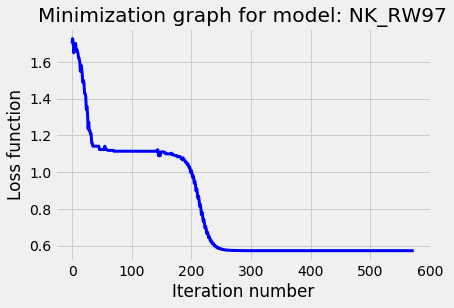

In [99]:
plt.ylabel('Loss function')
plt.xlabel('Iteration number')
plt.title('Minimization graph for model: {}'.format(getModelName()))
plt.plot(loss_array_4, lw=3, color="blue")

In [100]:
sixVar = iterative_deepening(1,6)

Hello
1.7008069999999997 4
1.726804 4
1.7008459999999999 4
1.6497259999999998 4
1.700291 4
1.7008069999999997 4
1.7008069999999997 4
1.659878 4
1.6693319999999998 4
1.6591520000000002 4
1.645861 4
1.619834 4
1.619834 4
1.595426 4
1.5485669999999998 4
1.583227 4
1.568066 4
1.540338 4
1.488129 4
1.499435 4
1.485848 4
1.4286590000000001 4
1.4286590000000001 4
1.4110559999999999 4
1.341731 4
1.3583150000000002 4
1.3175780000000001 4
1.234378 4
1.2710849999999998 4
1.226505 4
1.226505 4
1.208211 4
1.208211 4
1.157158 4
1.157158 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.141133 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.123121 4
1.122452 4
1.141133 4
1.124182 4
1.124182 4
1.1227740000000002 4
1.1220400000000001 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.118372 4
1.1139489999999999 4
1.1139489999999999 4
1.1139489999999999 4
1

0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.5723217999999999 5
0.57232179999

In [101]:
sixVar

 final_simplex: (array([[ 83.22740232, -11.96212026, 672.52105492,   1.38626435,
        677.54981636,  -3.9081098 ],
       [ 83.22735211, -11.9621203 , 672.52105641,   1.38626435,
        677.54981817,  -3.90810979],
       [ 83.22738331, -11.96212027, 672.52102457,   1.38626435,
        677.54981712,  -3.90810979],
       [ 83.2274115 , -11.96212027, 672.52101449,   1.38626435,
        677.54981675,  -3.90810979],
       [ 83.22740468, -11.96212025, 672.52102286,   1.38626435,
        677.54981644,  -3.9081098 ],
       [ 83.2273434 , -11.9621203 , 672.52107934,   1.38626435,
        677.5498182 ,  -3.90810979],
       [ 83.22736994, -11.9621203 , 672.52106862,   1.38626435,
        677.54981814,  -3.90810978]]), array([0.346523, 0.346523, 0.346523, 0.346523, 0.346523, 0.346523,
       0.346523]))
           fun: 0.34652299999999997
       message: 'Optimization terminated successfully.'
          nfev: 388
           nit: 167
        status: 0
       success: True
             x: a

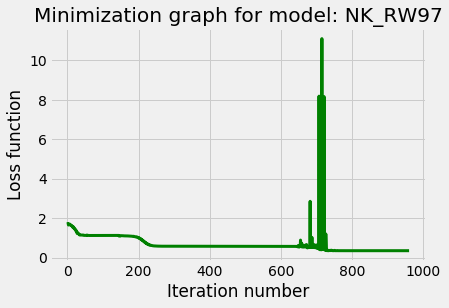

In [145]:
plt.ylabel('Loss function')
plt.xlabel('Iteration number')
plt.title('Minimization graph for model: {}'.format(getModelName()))
sixVarArray = loss_array_4[574:]
del sixVarArray[712]
plt.plot(sixVarArray, lw=3, color="green")

## Creating a surface plot of the Taylor rule

In [28]:
beta_pit = np.arange(0, 2.01, 0.1)
beta_yt = np.arange(0, 2.01, 0.1)
len(beta_pit)**2

441

In [29]:
#X = np.asarray([])
#Y = np.asarray([])
#Z = np.asarray([])

newZ = np.asarray([np.asarray([0.0 for i in np.arange(len(beta_pit))]) for i in np.arange(len(beta_pit))])
modelNum = 1
weights = [1,1,1,1]
index = 1

for i in range(len(beta_pit)):
    for j in range(len(beta_yt)):
        custom_coeff = [0, 0, 0, 0, beta_pit[i]/4, beta_pit[i]/4, beta_pit[i]/4, beta_pit[i]/4, 
                0, 0, 0, 0, 0, beta_yt[j], 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 0]
        scipy.io.savemat('variables.mat', dict(coefficients=custom_coeff, modelNumber = modelNum))
        eng.MMB(nargout = 0)
        Z_value = sum(unconditionalVariances().iloc[0] * weights)
        
        #X = np.append(X, beta_pit[i])
        #Y = np.append(Y, beta_yt[j])
        #Z = np.append(Z, Z_value)
        
        newZ[i][j] = Z_value
        print(index)
        index = index + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Text(0.5,0,'Beta_y')

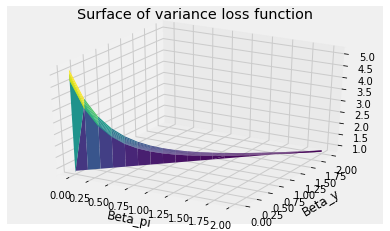

In [43]:
ax = plt.axes(projection='3d')
ax.plot_surface(beta_pit, beta_yt, newZ, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Surface of variance loss function');
ax.set_xlabel("Beta_pi")
ax.set_ylabel("Beta_y")

In [44]:
newZ

array([[0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724],
       [0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724],
       [0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724],
       [0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724, 0.839724, 0.839724, 0.839724,
        0.839724, 0.839724, 0.839724],
       [0.839724, 0.839724, 

In [45]:
np.savetxt("Z_optimize_surface.csv", newZ, delimiter=",")